# Load TraCE data
Ref He et al., 2011

In [2]:
import xarray as xr

path='D:/VScode/Last_deglaciation/TraCE_data/'

trace_allforcing_sat = xr.open_dataset(path+'trace.01-36.22000BP.cam2.TREFHT.22000BP_decavg_400BCE.nc')
trace_allforcing_sic=xr.open_dataset(path+'trace.01-36.22000BP.cam2.ICEFRAC.22000BP_decavg_400BCE.nc')


trace_allforcing_sat = trace_allforcing_sat.rename({'TREFHT': 'sat'})
trace_allforcing_sat = trace_allforcing_sat.rename({'time': 'age'})
trace_allforcing_sat['age'] = trace_allforcing_sat['age'] * -1000
trace_allforcing_sat['sat'] = trace_allforcing_sat['sat'] - 273.15
trace_allforcing_sat = trace_allforcing_sat[['sat']]


trace_allforcing_sic = trace_allforcing_sic.rename({'time': 'age'})
trace_allforcing_sic['age'] = trace_allforcing_sic['age'] * -1000
trace_allforcing_sic = trace_allforcing_sic[['ICEFRAC']]


trace_orb = xr.open_dataset(path + 'b30.00_4kaDVTj.cam2.ncrcat.ann.nc')
trace_orb = trace_orb.rename({'TREFHT': 'sat'})
trace_orb = trace_orb.rename({'time': 'age'})
trace_orb['age'] = trace_orb['age'] * -1000
trace_orb['sat'] = trace_orb['sat'] - 273.15 # convert to Celsius

trace_orb_sat = trace_orb[['sat']]
trace_orb_sic = trace_orb[['ICEFRAC']]


trace_ghg=xr.open_dataset('D:/VScode/Last_deglaciation/data_fig3/b30.00_4kaDVTk.cam2.ncrcat.ann.nc')
trace_ghg = trace_ghg.rename({'TREFHT': 'sat'})
trace_ghg = trace_ghg.rename({'time': 'age'})
trace_ghg['age'] = trace_ghg['age']* -1000
trace_ghg['sat'] = trace_ghg['sat']-273.15
trace_ghg_sat = trace_ghg[['sat']]
trace_ghg_sic = trace_ghg[['ICEFRAC']]


# Calculate the weighted average for the given latitude band for TraCE data

In [2]:
# Function to calculate the weighted average SAT
import numpy as np
import xarray as xr

def calculate_weighted_avg_sat(ds, lat_min=-75, lat_max=-60):
    # Calculate the weight based on latitude
    weight = np.cos(np.deg2rad(ds['lat']))
    weight = xr.where(weight < 0, 0, weight)
    ds['weight'] = weight

    # print the size of the original dataset
    print('size of the original dataset:',ds['sat'].size)
    
    # Select the subset based on latitude
    trace_orb_sat_subset = ds.sel(lat=slice(lat_min, lat_max))
    # PRINT THE SIZE OF THE SUBSET
    print('size of the subset:',trace_orb_sat_subset['sat'].size)

    # Broadcast the weights to the same shape as 'sat'
    weights_broadcasted = trace_orb_sat_subset['weight'].broadcast_like(trace_orb_sat_subset['sat'])

    # Calculate the sum of weighted 'sat' values and the sum of weights
    sum_weighted_sat = (trace_orb_sat_subset['sat'] * weights_broadcasted).sum(dim=['lat', 'lon'])
    sum_weights = weights_broadcasted.sum(dim=['lat', 'lon'])

    # Calculate the weighted average
    weighted_avg_sat = sum_weighted_sat / sum_weights

    return weighted_avg_sat



In [36]:

weighted_avg_allforcing = calculate_weighted_avg_sat(trace_allforcing_sat, lat_min=-70, lat_max=-50)
weighted_avg_orb = calculate_weighted_avg_sat(trace_orb_sat, lat_min=-70, lat_max=-50)
weighted_avg_ghg = calculate_weighted_avg_sat(trace_ghg_sat, lat_min=-70, lat_max=-50)

# weighted_avg_moc = weighted_avg_allforcing - weighted_avg_orb - weighted_avg_ghg


# weighted_avg_orb_relative = weighted_avg_orb - weighted_avg_orb[-1]
# weighted_avg_ghg_relative = weighted_avg_ghg - weighted_avg_ghg[-1]
# weighted_avg_moc = weighted_avg_allforcing - weighted_avg_orb_relative - weighted_avg_ghg_relative


# Calculate the mean of the last 10 values for orb and ghg
mean_last_10_orb = np.mean(weighted_avg_orb[:10])
mean_last_10_ghg = np.mean(weighted_avg_ghg[:10])

# Subtract these means from the respective arrays to get relative values
weighted_avg_orb_relative = weighted_avg_orb - mean_last_10_orb
weighted_avg_ghg_relative = weighted_avg_ghg - mean_last_10_ghg

# Calculate weighted_avg_moc with the adjusted relative values
weighted_avg_moc = weighted_avg_allforcing - weighted_avg_orb_relative - weighted_avg_ghg_relative


size of the original dataset: 10156032
size of the subset: 1269504
size of the original dataset: 10156032
size of the subset: 1269504
size of the original dataset: 10156032
size of the subset: 1269504


# Calculate sea ice area forTraCE

In [4]:
import xarray as xr
import numpy as np
import pickle

def calculate_seaice_area(ds_seaice, variable_name='sic',lat_min=-90,lat_max=0):    
    # Subset dataset for latitude from -90 to 0
    ds_seaice_subset = ds_seaice.sel(lat=slice(lat_min, lat_max))

    # Constants
    R = 6371  # Earth's radius in km
    delta_theta = 2.5 / 180 * np.pi  # 2.5 degree in radians

    # Convert latitude values to radians and compute latitudinal boundaries
    lat_radians = np.radians(ds_seaice_subset['lat'].values)
    lat_boundaries = (lat_radians[:-1] + lat_radians[1:]) / 2

    # area of each grid, 
    # Ref: https://www.johndcook.com/blog/2023/02/21/sphere-grid-area/#:~:text=Area%20of%20latitude%2Flongitude%20grid&text=A%20%3D%20%CF%80%20R%C2%B2%20(sin%20%CF%86,1%20%E2%88%92%20%CE%B82)%2F180.
    A = R**2 * delta_theta * (np.sin(lat_boundaries[1:]) - np.sin(lat_boundaries[:-1]))
    A_center_lats = ds_seaice_subset['lat'].values[1:-1]

    # Reduce dataset size
    ds_seaice_subset_reduced = ds_seaice_subset.isel(lat=slice(1, -1))

    # Create an xarray DataArray for A
    A_xr = xr.DataArray(A, dims=["lat"], coords={"lat": A_center_lats})

    # Multiply sic data with A
    sic = ds_seaice_subset_reduced[variable_name]
    sic_area = sic * A_xr

    # Sum up the resulting product
    LGMR_sic_area = sic_area.sum(dim=["lat", "lon"]).values / 1e6
    # print('LGMR_sic_area:', LGMR_sic_area.shape)

    # Add age to LGMR_sic_area
    LGMR_sic_area = np.column_stack((ds_seaice_subset_reduced['age'].values, LGMR_sic_area))

    return LGMR_sic_area


In [39]:


asice_trace_allforcing=calculate_seaice_area(trace_allforcing_sic, variable_name='ICEFRAC') 
asice_trace_orb=calculate_seaice_area(trace_orb_sic, variable_name='ICEFRAC')
asice_trace_ghg=calculate_seaice_area(trace_ghg_sic, variable_name='ICEFRAC')

# asice_trace_moc = np.column_stack((asice_trace_allforcing[:, 0], asice_trace_allforcing[:, 1] - asice_trace_orb[:, 1] - asice_trace_ghg[:, 1] - asice_trace_orb[:, 1]))
# asice_trace_orb_relative = asice_trace_orb[:, 1] - asice_trace_orb[-1, 1]
# asice_trace_ghg_relative = asice_trace_ghg[:, 1] - asice_trace_ghg[-1, 1]
# asice_trace_moc_relative = asice_trace_allforcing[:, 1] - asice_trace_orb_relative - asice_trace_ghg_relative - asice_trace_orb_relative
# asice_trace_moc = np.column_stack((asice_trace_allforcing[:, 0], asice_trace_moc_relative))


mean_last_10_orb_sic = np.mean(asice_trace_orb[:10, 1])
mean_last_10_ghg_sic = np.mean(asice_trace_ghg[:10, 1])

# Subtract these means from the respective arrays to get relative sea ice areas
asice_trace_orb_relative = asice_trace_orb[:, 1] - mean_last_10_orb_sic
asice_trace_ghg_relative = asice_trace_ghg[:, 1] - mean_last_10_ghg_sic

# Calculate asice_trace_moc with the adjusted relative values
asice_trace_moc_relative = asice_trace_allforcing[:, 1] - asice_trace_orb_relative - asice_trace_ghg_relative - asice_trace_orb_relative
asice_trace_moc = np.column_stack((asice_trace_allforcing[:, 0], asice_trace_moc_relative))


# Plot

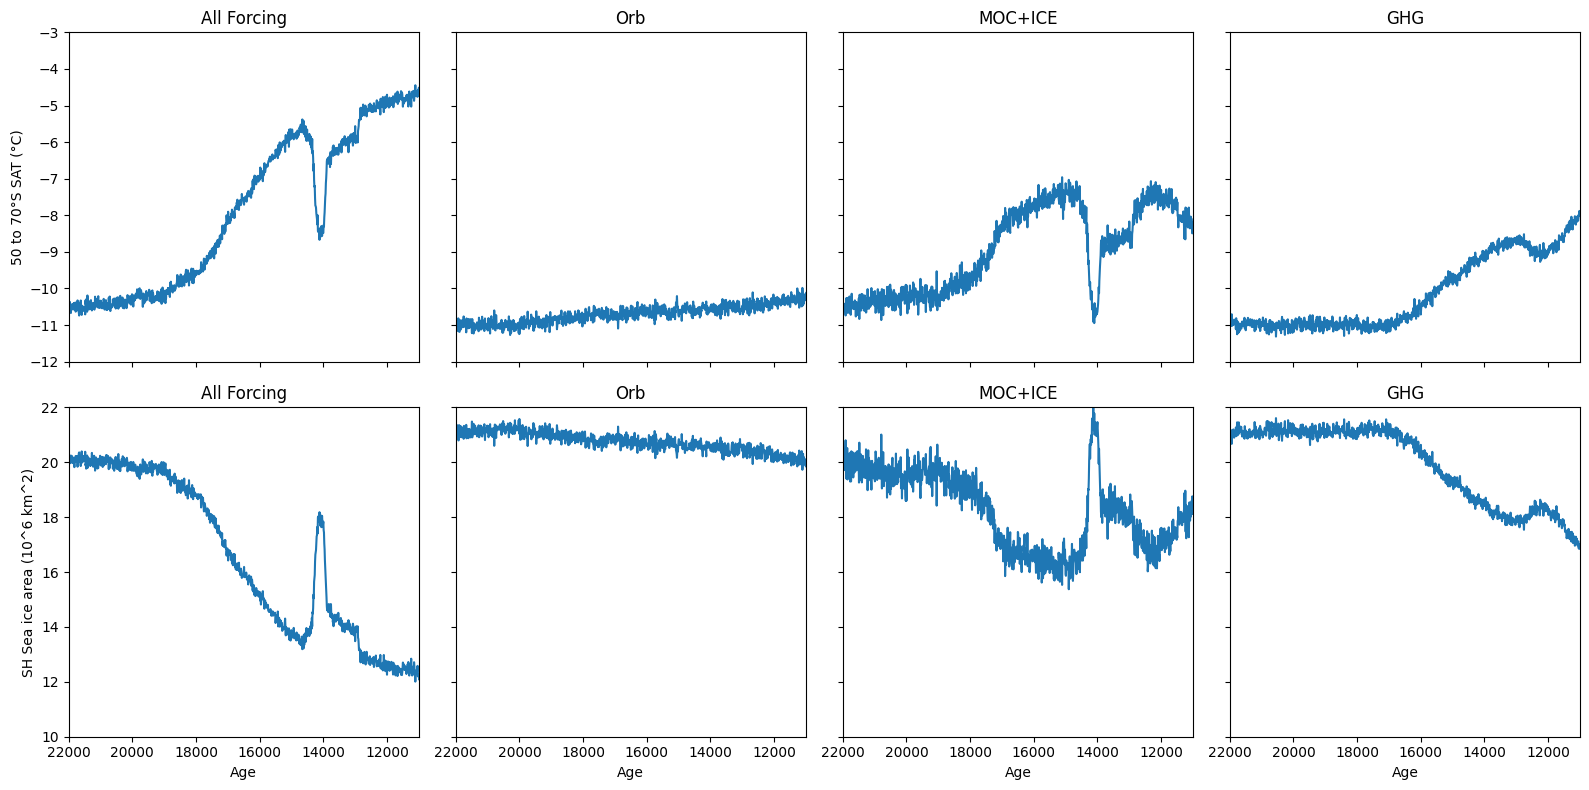

In [47]:
import matplotlib.pyplot as plt

sat_data = {
    'All Forcing': weighted_avg_allforcing,
    'Orb': weighted_avg_orb,
    'MOC+ICE': weighted_avg_moc,  # Assuming this is calculated elsewhere
    'GHG': weighted_avg_ghg
}

asice_data = {
    'All Forcing': asice_trace_allforcing[:, 1],  # Assuming the second column is the area
    'Orb': asice_trace_orb[:, 1],
    'MOC+ICE': asice_trace_moc[:, 1],  # Assuming this is calculated and the second column is the area
    'GHG': asice_trace_ghg[:, 1]
}
age=weighted_avg_allforcing.age.values

fig, axs = plt.subplots(2, 4, figsize=(16, 8))  # 2 rows, 4 columns with specified adjustments

# Adjusted plot with uniform y-limits for rows and x-limits for all plots
y_limits_sat = (-12, -3)
y_limits_asice = (10, 22)
x_limits = (22000,11000)

# Plot mock SAT data with adjustments
for i, (key, value) in enumerate(sat_data.items()):
    axs[0, i].plot(age, value)
    axs[0, i].set_title(f'{key}')
    axs[0, i].set_ylim(y_limits_sat)
    axs[0, i].set_xlim(x_limits)
    # set y_label
    if i == 0:
        axs[0, i].set_ylabel('50 to 70°S SAT (°C)')

# Plot mock sea ice area data with adjustments
for i, (key, value) in enumerate(asice_data.items()):
    axs[1, i].plot(age, value)
    axs[1, i].set_title(f'{key}')
    axs[1, i].set_ylim(y_limits_asice)
    axs[1, i].set_xlim(x_limits)
    # set y_label
    if i == 0:
        axs[1, i].set_ylabel('SH Sea ice area (10^6 km^2)')

for ax in axs.flat:
    ax.set(xlabel='Age')
    ax.label_outer()

plt.tight_layout()
plt.show()



c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


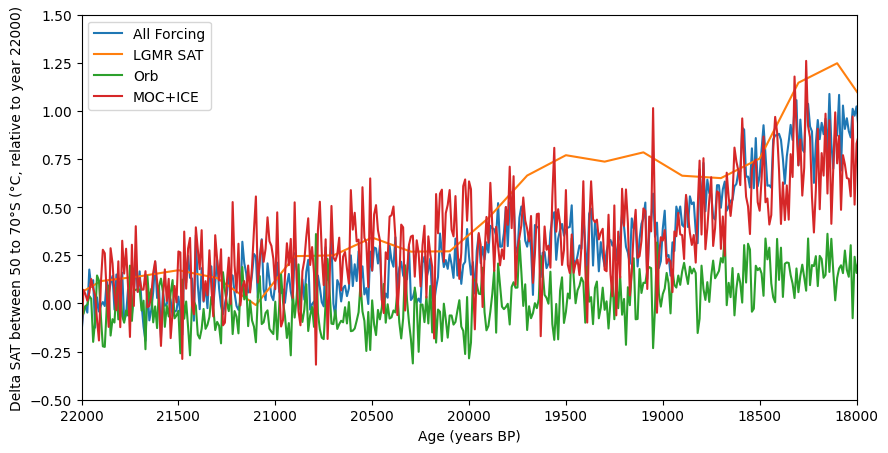

In [60]:
import matplotlib.pyplot as plt

# read the LGMR SAT of 50 to 70°S （weighted_avg_sat_mean）
import pickle
with open('D:/VScode/Last_deglaciation/data_fig3/weighted_avg_sat_mean.pickle', 'rb') as f:
    weighted_avg_sat_mean = pickle.load(f)

# open the 'LGMR_GMST_ens.nc' file
ds_sat = xr.open_dataset('data/LGMR_SAT_climo.nc')

ds_sat_age_np = ds_sat['age'].values
weighted_avg_sat_mean_np = weighted_avg_sat_mean.values


import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pickle

# Assuming `weighted_avg_allforcing`, `sat_data['Orb']`, and `sat_data['MOC+ICE']` are defined

# Modify the plotting code
plt.figure(figsize=(10, 5))

# Adjust each dataset to be relative to the mean of its first 10 values
def adjust_to_initial_mean(data,n=10):
    return data - np.mean(data[:n])

# Adjusted plotting for each dataset
plt.plot(age, adjust_to_initial_mean(sat_data['All Forcing']), label='All Forcing')
plt.plot(ds_sat_age_np, weighted_avg_sat_mean_np-weighted_avg_sat_mean_np[-10], label='LGMR SAT')
plt.plot(age, adjust_to_initial_mean(sat_data['Orb']), label='Orb')
plt.plot(age, adjust_to_initial_mean(sat_data['MOC+ICE']), label='MOC+ICE')

# Setting labels and title
plt.xlabel('Age (years BP)')
plt.ylabel('Delta SAT between 50 to 70°S (°C, relative to year 22000)')
# plt.title('Adjusted SAT Data Comparison')
plt.ylim(-0.5, 1.5)  # Assuming you still want to set specific y-limits
plt.xlim(22000, 18000)  # Setting the x-axis limits as requested

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()




# # Plotting SAT data for "All Forcing", "Orb", and "MOC"
# plt.figure(figsize=(10, 5))

# age=weighted_avg_allforcing.age.values

# # Plotting
# plt.plot(age, sat_data['All Forcing'], label='All Forcing')
# # plot the LGMR SAT of 50 to 70°S
# plt.plot(ds_sat_age_np, weighted_avg_sat_mean_np, label='LGMR SAT')
# plt.plot(age, sat_data['Orb'], label='Orb')
# plt.plot(age, sat_data['MOC+ICE'], label='MOC+ICE')

# # Setting labels and title
# plt.xlabel('Age (years BP)')
# plt.ylabel('SAT (°C)')
# plt.title('SAT Data Comparison')
# # set y-limits
# plt.ylim(-12, -9)

# plt.xlim(22000, 18000)

# # Adding a legend
# plt.legend()

# # Displaying the plot
# plt.show()
